In [1]:
import pandas as pd

file_path = "fact_check_insights/claim_review.csv"
df = pd.read_csv(file_path)#244560

c:\users\teramoto\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (14,24,25,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
# 使用する列のみ選択（itemReviewed.firstAppearance.urlは226005がNan値の為削除）
df = df[['id', 'datePublished', 
         'itemReviewed.datePublished','claimReviewed',
         'author.name','reviewRating.@type',
         'reviewRating.ratingValue',
         "reviewRating.alternateName"]]

In [3]:
len(df)

244560

In [4]:
# NaNの数を表示する
print(df.isna().sum())

id                                 0
datePublished                  12266
itemReviewed.datePublished     63509
claimReviewed                    440
author.name                    25295
reviewRating.@type               943
reviewRating.ratingValue      105932
reviewRating.alternateName      2114
dtype: int64


In [7]:
# 'datePublished', 'itemReviewed.datePublished'両方含むもののみ残す
df = df.dropna(subset=['datePublished', 'itemReviewed.datePublished'])#172424件

In [8]:
# 日付の列をstr型からdate型に変換
df["datePublished"] = pd.to_datetime(df["datePublished"], errors='coerce',utc=True)
df["itemReviewed.datePublished"] = pd.to_datetime(df["itemReviewed.datePublished"], errors='coerce',utc=True)

<ipython-input-8-29ee7f29ee78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datePublished"] = pd.to_datetime(df["datePublished"], errors='coerce',utc=True)
<ipython-input-8-29ee7f29ee78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["itemReviewed.datePublished"] = pd.to_datetime(df["itemReviewed.datePublished"], errors='coerce',utc=True)


In [9]:
# タイムゾーン情報がない行を削除
df = df[df["datePublished"].apply(lambda x: x.tzinfo is not None)]
df = df[df["itemReviewed.datePublished"].apply(lambda x: x.tzinfo is not None)]

In [10]:
# タイムゾーン情報がない行をカウント
no_timezone_count = df["datePublished"].apply(lambda x: x.tzinfo is None).sum()
print(str(no_timezone_count)+"/"+str(len(df)))

no_timezone_count = df["itemReviewed.datePublished"].apply(lambda x: x.tzinfo is None).sum()
print(str(no_timezone_count)+"/"+str(len(df)))

0/172305
0/172305


In [11]:
df['date_diff'] = (df['datePublished'] - df['itemReviewed.datePublished']).dt.total_seconds() / (3600*24)  # 差を日数で表示

In [40]:
# ファクトチェック実行までの時間のヒストグラムを作成
import matplotlib.pyplot as plt

def Time_hist(df):
    # ヒストグラムを作成
    plt.figure(figsize=(5, 3))  # グラフのサイズを指定
    plt.hist(df['date_diff'].dropna(), bins=100, range=(-100, 100), color='blue', edgecolor='black')  # rangeを指定して範囲を制限
    plt.title('Histogram of Differences between making claim and fact-checking')  # タイトル
    plt.xlabel('Days Difference')  # X軸のラベル
    plt.ylabel('Frequency')  # Y軸のラベル
    plt.grid(True)  # グリッドを表示
    plt.show()  # プロットを表示

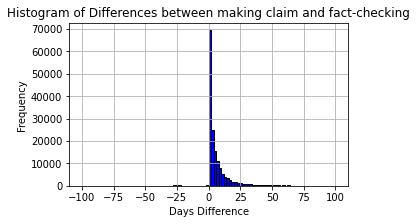

In [41]:
Time_hist(df)

In [13]:
date_diff_counts = df['date_diff'].value_counts().reset_index()
date_diff_counts.columns = ['date_diff_hours', 'frequency']  # 列名をわかりやすく変更

In [ ]:
# 需要度がついているものでも同じことをやったほうがいい(リーク問題は一旦おいておく)
# 現状数日以内でできているので，順序をつける必要性はあるのか？
# 時間と関係して変動する項目はないか？（トピックとか）
# 団体ごとの差を見てみるといいかも
# ファクトチェック対象が個人なのかメディアなのか　で分けたほうがいい
# チェックのどの部分に時間がかかっているのか

In [62]:
# Yes or No のブール値ではなく，連続値で評価させられないか？

# 日本のファクトチェックの場合，結構時間がかかっている
# 団体ごとに得意なメディアやフィールドが

In [ ]:
# WISE向けの骨格を作成
# 発見は何か，リサーチクエスチョンは何か

In [14]:
date_diff_counts.head(10)

,date_diff_hours,frequency
0,0.0,40077
1,1.0,14510
2,2.0,10575
3,3.0,7562
4,4.0,5892
5,5.0,4635
6,6.0,3775
7,7.0,3208
8,8.0,2624
9,9.0,2145


c:\users\teramoto\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arrays\datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


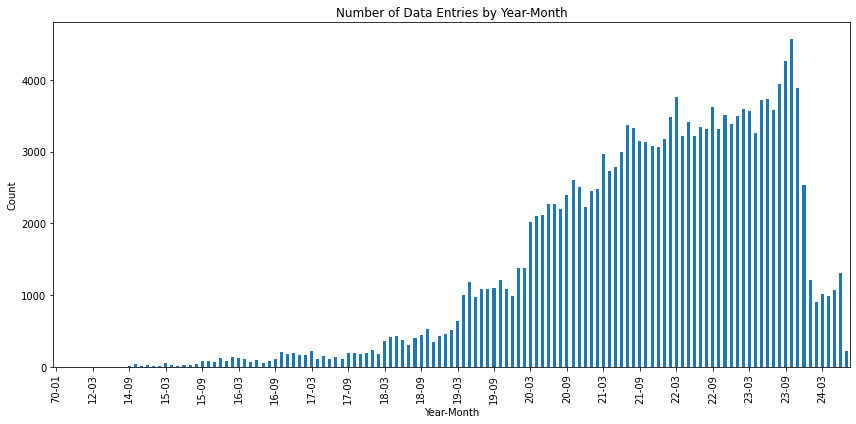

In [30]:
# 投稿日のヒストグラムを作成
import matplotlib.pyplot as plt

df['year_month'] = df['datePublished'].dt.to_period('M')
year_month_counts = df['year_month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
year_month_counts.plot(kind='bar')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Number of Data Entries by Year-Month')

# 6ヶ月ごとの目盛りを表示し、年を2桁表記に変更
tick_labels = year_month_counts.index.to_timestamp()
tick_labels_formatted = tick_labels.strftime('%y-%m')
plt.xticks(ticks=range(0, len(tick_labels), 6), labels=tick_labels_formatted[::6], rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# この分布はなぜ？

In [ ]:
del filtered_df

In [17]:
# 特定の日付以降のデータをフィルタリング
specific_date = '2021-10-01'  ## GPT-3.5以降:100833
gpt35_df = df[df['datePublished'] >= pd.to_datetime(specific_date,utc=True)]
print(gpt35_df.shape[0])

100833


In [21]:
gpt35_df['language'] = gpt35_df['claimReviewed'].apply(detect_language)

<ipython-input-21-4a4b413256e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpt35_df['language'] = gpt35_df['claimReviewed'].apply(detect_language)


In [48]:
# specific_date = '2023-11-01'  ## GPT-4o以降:13084
# gpt4o_df = gpt35_df[gpt35_df['datePublished'] >= pd.to_datetime(specific_date,utc=True)]

In [49]:
# specific_date = '2024-01-01'  ## GPT-4o以降:13084
# gpt4_df = gpt4o_df[gpt4o_df['datePublished'] >= pd.to_datetime(specific_date,utc=True)]

In [20]:
# 言語検出を行い、結果を新たな列に格納
import pandas as pd
from langdetect import detect, DetectorFactory

# 安定した言語検出のためにランダムシードを設定
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'  # 言語検出ができない場合は 'unknown' を返す

In [50]:
# save_bin("new_data/gpt35_df.bin",gpt35_df)
# save_bin("new_data/gpt4o_df.bin",gpt4o_df)
# save_bin("new_data/gpt4_df.bin",gpt4_df)

In [23]:
import pickle
def read_bin(filename):
    with open(filename,'rb') as bf:
        bin_data = pickle.load(bf)
    return bin_data

def save_bin(filename,data):
    with open(filename,'wb') as bf:
        pickle.dump(data,bf)

In [24]:
save_bin("new_data/gpt35_df.bin",gpt35_df)

In [44]:
language_counts = gpt35_df['language'].value_counts().reset_index()
language_counts.head(3)

,index,language
0,en,26816
1,ar,14388
2,pt,6340


en


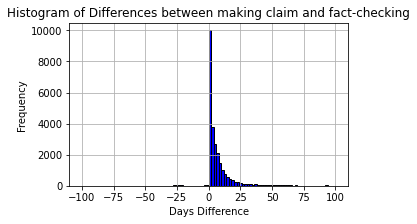

ar


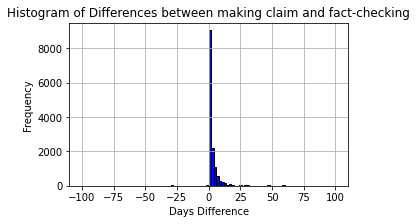

pt


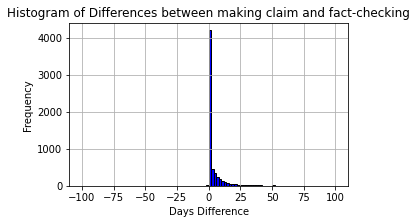

es


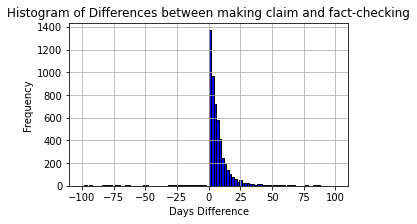

hi


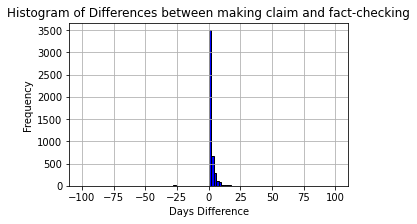

it


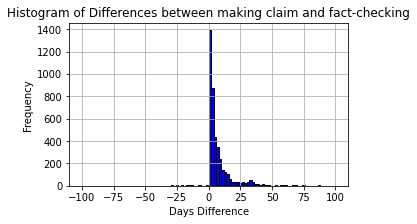

de


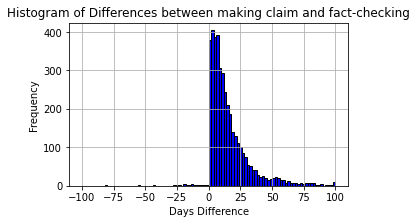

tr


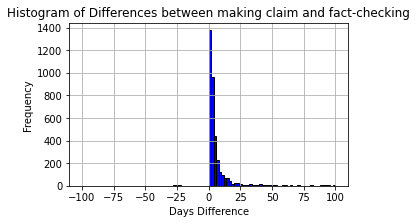

pl


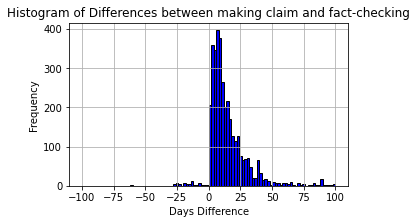

bn


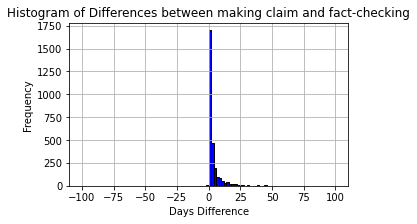

In [42]:
for lang in ['en', 'ar', 'pt', 'es', 'hi', 'it', 'de', 'tr', 'pl', 'bn']:
    print(lang)
    Time_hist(gpt35_df[gpt35_df['language'] == lang])

In [ ]:
## 一旦言語ごとに分析を行わず，全て英語で流す

In [51]:
language_counts = gpt4_df['language'].value_counts().reset_index()
language_counts.head(3)

,index,language
0,en,3541
1,es,506
2,te,352


In [52]:
len(gpt4_df)

6718

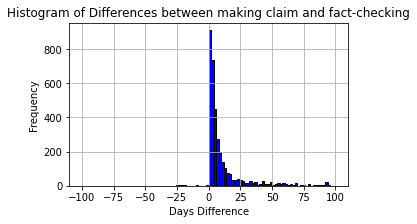

In [53]:
Time_hist(gpt4_df[gpt4_df['language'] == "en"])